1. Данные должны быть корректно предобработаны.

2. Представлена визуализация в ходе анализа данных (сколько представителей каждого класса представлено в датасете).

3. При обучении моделей используется K-блочная кросс-валидация.

4. Построить следующие модели классификации с использованием подбора гиперпараметров моделей: логистическая регрессия, KNN, деревья решений, лес.

5. Для каждой модели вывести метрики качества в виде отчета классификации (classification_report).

6. Вывести результаты предсказаний моделей для одного объекта из тестовых данных, сравнить с истинным значением.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("flats.csv", delimiter=",", encoding="Windows-1251")
df = df.fillna("")
df.iloc[:, 0:1] = df.iloc[:, 0:1].replace("", "N/A")
df.iloc[:, 2:4] = df.iloc[:, 2:4].replace("", 0)
df.iloc[:, 4] = df.iloc[:, 4].astype(int)
df = df.drop_duplicates()
df = df[(df["Address"] != "N/A") & (df["Floor"] != 0) & (df["Square, м2"] != 0) & (df["Price, руб."] != 0)]
print(df.dtypes)
df

Flat type      object
Address        object
Floor          object
Square, м2     object
Price, руб.     int64
dtype: object


,Flat type,Address,Floor,"Square, м2","Price, руб."
0,свердловский вариант,"Жемчужная , 21",4/5,"55,6/32/9",3600000
1,N/A,"Набережная, 7/2",3/3,"45,6/35/8",4999999
2,N/A,"ул Куйбышева, 24",4/4,"52,8/35/11",4500000
3,N/A,"ул Сталеваров, 17/2",16/16,"56,4/0/0",4500000
4,N/A,"Труда, 35",8/9,49/32/8,3600000
...,...,...,...,...,...
328,N/A,"Зеленый Лог, 69/1",2/3,"55,7/29,5/12,7",3287000
329,N/A,"Зеленый Лог, 69/1",2/3,"78/62,7/15",4446000
330,N/A,"Сочинская, 47/1",2/3,50/36/12,2590000
331,N/A,"ул. Курортная, 33",1/5,"47,3/0/10",3000000


In [12]:
flats_df = df

# Площадь
total_sq, living_sq, kitchen_sq = [], [], []
for i in flats_df['Square, м2']:
  i = i.replace(',', '.')
  temp = i.split('/')
  total_sq.append(round(float(temp[0]), 2))
  living_sq.append(round(float(temp[1]), 2))
  kitchen_sq.append(round(float(temp[2]), 2))

# Этаж
curr_floors, total_floors = [], []
for i in flats_df['Floor']:
  if type(i) != 'int':
    temp = i.split('/')
    if temp[0] == '':
      curr_floors.append(0)
    if temp[1] == '':
      total_floors.append(0)
    else:
      curr_floors.append(int(temp[0]))
      total_floors.append(int(temp[1]))

flats_df = pd.DataFrame({"Flat type":flats_df["Flat type"],
                         "Current floor": curr_floors,
                         "Total floors":total_floors,
                         "Total area":total_sq,
                         "Living area":living_sq,
                         "Kitchen area":kitchen_sq,
                         "Price":flats_df["Price, руб."]})

flats_df

,Flat type,Current floor,Total floors,Total area,Living area,Kitchen area,Price
0,свердловский вариант,4,5,55.6,32.0,9.0,3600000
1,N/A,3,3,45.6,35.0,8.0,4999999
2,N/A,4,4,52.8,35.0,11.0,4500000
3,N/A,16,16,56.4,0.0,0.0,4500000
4,N/A,8,9,49.0,32.0,8.0,3600000
...,...,...,...,...,...,...,...
328,N/A,2,3,55.7,29.5,12.7,3287000
329,N/A,2,3,78.0,62.7,15.0,4446000
330,N/A,2,3,50.0,36.0,12.0,2590000
331,N/A,1,5,47.3,0.0,10.0,3000000


In [13]:
flats_df['Flat type'].value_counts()

Flat type
N/A                     254
брежневка                14
раздельная               13
улучшенная               11
нестандартная             9
хрущевка                  6
старой планировки         6
смежная                   4
свердловский вариант      3
сталинский вариант        3
евродвушка                3
гребенка                  2
97 серия                  2
хабаровский вариант       1
раздельная брежн          1
евротрешка                1
Name: count, dtype: int64

In [24]:
flats_df['Flat type'] = flats_df['Flat type'].replace({
    'N/A':0,
    'брежневка':1,
    'раздельная':2,
    'улучшенная':3,
    'нестандартная':4,
    'хрущевка':5,
    'старой планировки':6,
    'смежная':7,
    'свердловский вариант':8,
    'сталинский вариант':9,
    'евродвушка':10,
    'гребенка':11,
    '97 серия':12,
    'хабаровский вариант':13,
    'раздельная брежн':14,
    'евротрешка':15,
    })

flats_df['Flat type'].value_counts()

Flat type
0     254
1      14
2      13
3      11
4       9
5       6
6       6
7       4
8       3
9       3
10      3
11      2
12      2
13      1
14      1
15      1
Name: count, dtype: int64

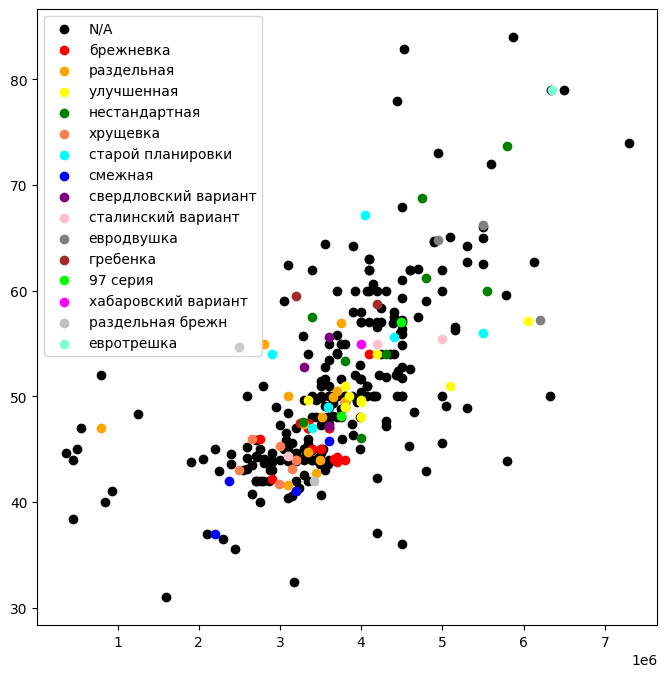

In [15]:
plt.figure(figsize=(8, 8))

plt.scatter(flats_df["Price"][flats_df['Flat type'] == 0], flats_df["Total area"][flats_df['Flat type'] == 0], c="black", label="N/A")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 1], flats_df["Total area"][flats_df['Flat type'] == 1], c="red", label="брежневка")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 2], flats_df["Total area"][flats_df['Flat type'] == 2], c="orange", label="раздельная")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 3], flats_df["Total area"][flats_df['Flat type'] == 3], c="yellow", label="улучшенная")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 4], flats_df["Total area"][flats_df['Flat type'] == 4], c="green", label="нестандартная")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 5], flats_df["Total area"][flats_df['Flat type'] == 5], c="coral", label="хрущевка")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 6], flats_df["Total area"][flats_df['Flat type'] == 6], c="cyan", label="старой планировки")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 7], flats_df["Total area"][flats_df['Flat type'] == 7], c="blue", label="смежная")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 8], flats_df["Total area"][flats_df['Flat type'] == 8], c="purple", label="свердловский вариант")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 9], flats_df["Total area"][flats_df['Flat type'] == 9], c="pink", label="сталинский вариант")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 10], flats_df["Total area"][flats_df['Flat type'] == 10], c="grey", label="евродвушка")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 11], flats_df["Total area"][flats_df['Flat type'] == 11], c="brown", label="гребенка")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 12], flats_df["Total area"][flats_df['Flat type'] == 12], c="lime", label="97 серия")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 13], flats_df["Total area"][flats_df['Flat type'] == 13], c="magenta", label="хабаровский вариант")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 14], flats_df["Total area"][flats_df['Flat type'] == 14], c="silver", label="раздельная брежн")
plt.scatter(flats_df["Price"][flats_df['Flat type'] == 15], flats_df["Total area"][flats_df['Flat type'] == 15], c="aquamarine", label="евротрешка")

plt.legend()

plt.show()

In [29]:
X = flats_df.drop('Flat type',axis=1).to_numpy()
y = flats_df['Flat type'].to_numpy()

K блочная крос валидация для разделения данных

In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
kf.get_n_splits(X)
print(kf)


KFold(n_splits=3, random_state=None, shuffle=False)


In [31]:
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

Нормализация

In [32]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [34]:
from sklearn.metrics import accuracy_score

Логическая регрессия

In [40]:
from sklearn.linear_model import LogisticRegression
accuracies = {}

lr = LogisticRegression()
lr.fit(X_train, y_train)
acc = lr.score(X_test, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.6667


In [ ]:
classification_report

Accuracy=(TP+TN)/(TP+TN+FP+FN) точность Точность можно рассматривать как меру точности классификатора. Для каждого класса он определяется как отношение истинных срабатываний к сумме истинных и ложных срабатываний. Другими словами, «для всех случаев, классифицированных как положительные, какой процент был правильным?» TP/(TP+FP)

отзывать Полнота — это мера полноты классификатора; способность классификатора правильно находить все положительные экземпляры. Для каждого класса он определяется как отношение истинно положительных результатов к сумме истинно положительных и ложноотрицательных результатов. Другими словами, «для всех случаев, которые были действительно положительными, какой процент был классифицирован правильно?» TP/(TP+FN)

счет f1 Показатель F 1 представляет собой взвешенное гармоническое среднее значение точности и полноты, так что наилучший показатель равен 1,0, а наихудший - 0,0. Вообще говоря, баллы F 1 ниже, чем показатели точности, поскольку они включают в свои вычисления точность и полноту. Как правило, для сравнения моделей классификаторов следует использовать средневзвешенное значение F 1 , а не глобальную точность. f1 score = 2(precision*recall)/(precision+recall)

поддерживать Поддержка — это количество фактических вхождений класса в указанном наборе данных. Несбалансированная поддержка в обучающих данных может указывать на структурные недостатки в сообщаемых оценках классификатора и может указывать на необходимость стратифицированной выборки или повторной балансировки. Поддержка не меняется между моделями, а вместо этого диагностирует процесс оценки.

In [48]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3 , 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.69      0.96      0.80        77
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5

   micro avg       0.67      0.72      0.69       103
   macro avg       0.10      0.14      0.11       103
weighted avg       0.52      0.72      0.60       103



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Метод к ближайших соседей

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)  # n_neighbors means k
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)

print("{} NN Score: {:.4f}".format(3, knn.score(X_test, y_test)))

3 NN Score: 0.6757


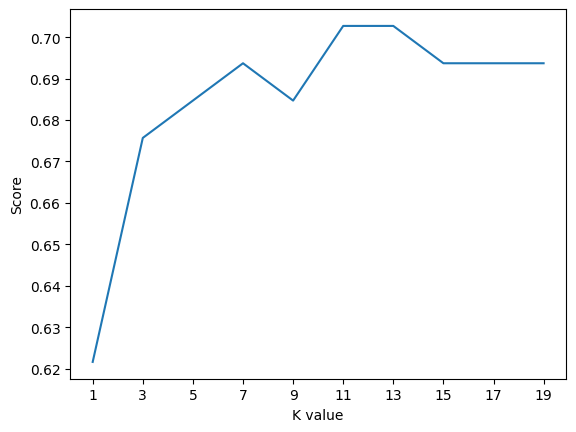

Maximum KNN Score is 0.7027


In [53]:
scoreList = []
for i in range(1, 20, 2):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))

plt.plot(range(1, 20, 2), scoreList)
plt.xticks(np.arange(1, 20, 2))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.4f}".format(acc))

In [54]:
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

Accuracy=(TP+TN)/(TP+TN+FP+FN)
точность
Точность можно рассматривать как меру точности классификатора. Для каждого класса он определяется как отношение истинных срабатываний к сумме истинных и ложных срабатываний. Другими словами, «для всех случаев, классифицированных как положительные, какой процент был правильным?» TP/(TP+FP)

отзывать
Полнота — это мера полноты классификатора; способность классификатора правильно находить все положительные экземпляры. Для каждого класса он определяется как отношение истинно положительных результатов к сумме истинно положительных и ложноотрицательных результатов. Другими словами, «для всех случаев, которые были действительно положительными, какой процент был классифицирован правильно?»
TP/(TP+FN)

счет f1
Показатель F 1 представляет собой взвешенное гармоническое среднее значение точности и полноты, так что наилучший показатель равен 1,0, а наихудший - 0,0. Вообще говоря, баллы F 1 ниже, чем показатели точности, поскольку они включают в свои вычисления точность и полноту. Как правило, для сравнения моделей классификаторов следует использовать средневзвешенное значение F 1 , а не глобальную точность. f1 score = 2(precision*recall)/(precision+recall)

поддерживать
Поддержка — это количество фактических вхождений класса в указанном наборе данных. Несбалансированная поддержка в обучающих данных может указывать на структурные недостатки в сообщаемых оценках классификатора и может указывать на необходимость стратифицированной выборки или повторной балансировки. Поддержка не меняется между моделями, а вместо этого диагностирует процесс оценки.

In [55]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3 , 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82        77
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5

   micro avg       0.69      0.75      0.72       103
   macro avg       0.17      0.18      0.16       103
weighted avg       0.54      0.75      0.62       103



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Деревья решений

In [56]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

acc = dtc.score(X_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 0.5856


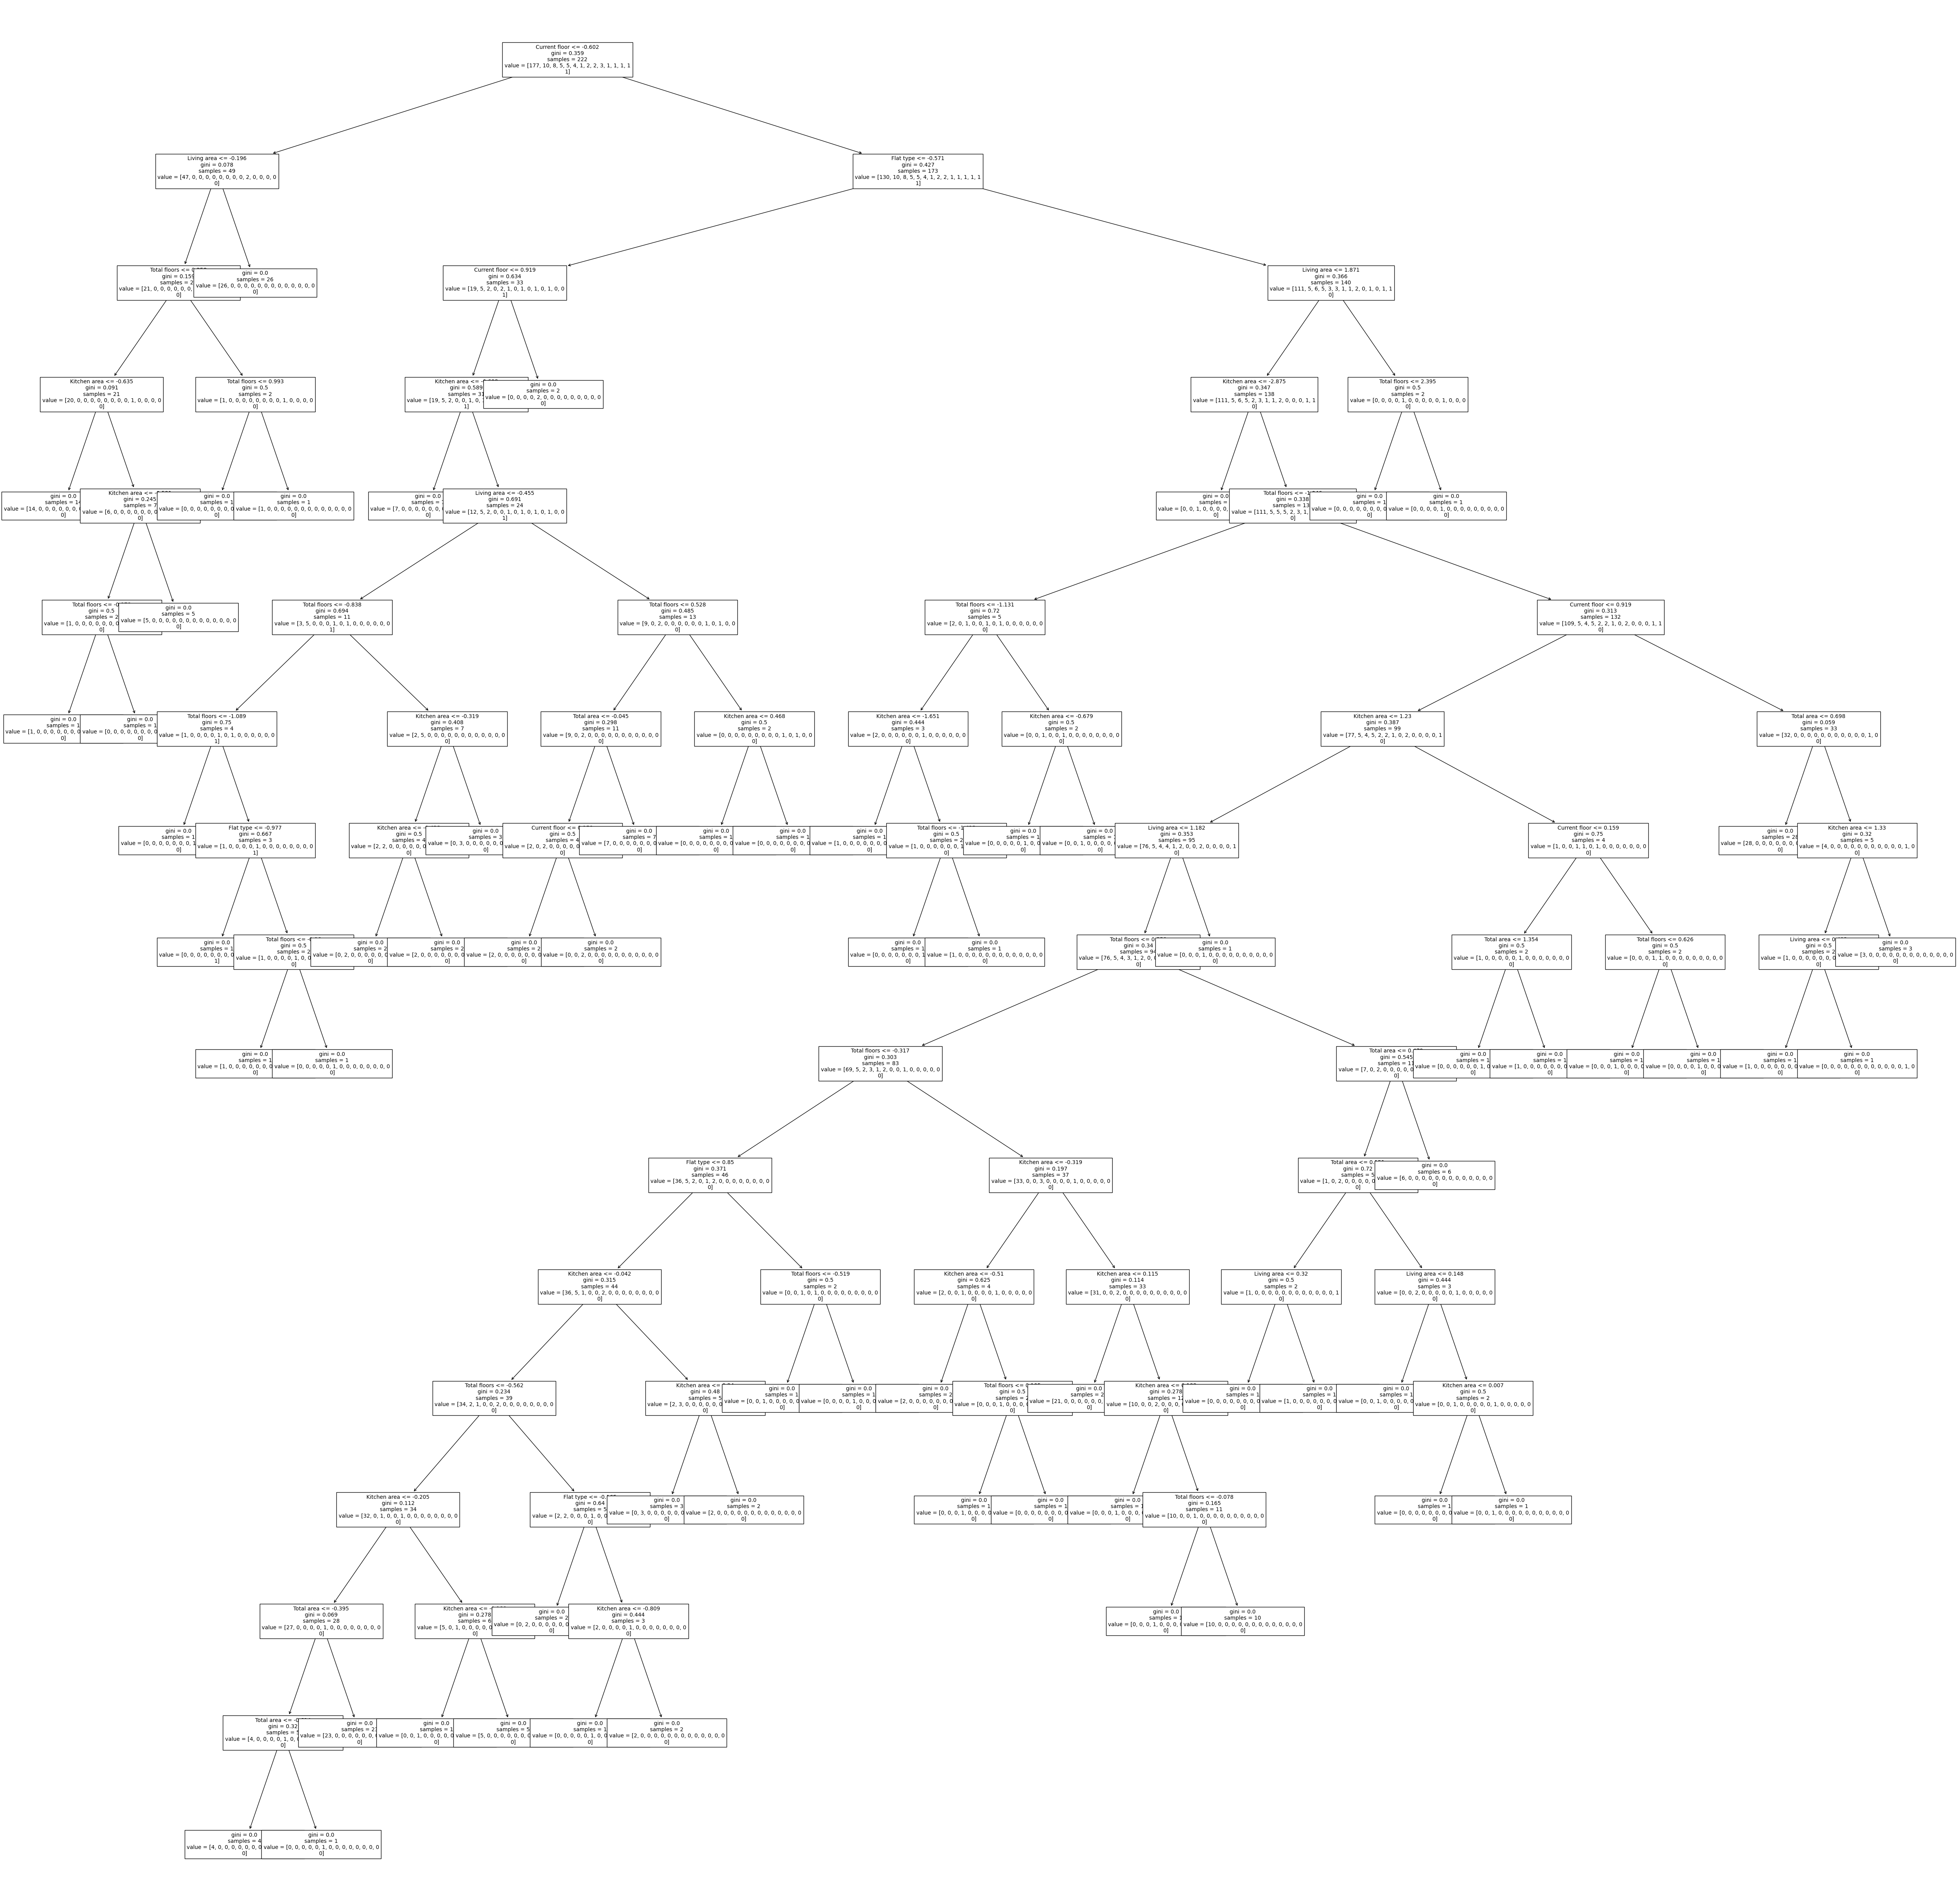

In [60]:
from sklearn import tree

plt.figure(figsize=(64, 64))
tree.plot_tree(dtc, feature_names=flats_df.columns,fontsize=10);

In [61]:
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

Accuracy=(TP+TN)/(TP+TN+FP+FN) точность Точность можно рассматривать как меру точности классификатора. Для каждого класса он определяется как отношение истинных срабатываний к сумме истинных и ложных срабатываний. Другими словами, «для всех случаев, классифицированных как положительные, какой процент был правильным?» TP/(TP+FP)

отзывать Полнота — это мера полноты классификатора; способность классификатора правильно находить все положительные экземпляры. Для каждого класса он определяется как отношение истинно положительных результатов к сумме истинно положительных и ложноотрицательных результатов. Другими словами, «для всех случаев, которые были действительно положительными, какой процент был классифицирован правильно?» TP/(TP+FN)

счет f1 Показатель F 1 представляет собой взвешенное гармоническое среднее значение точности и полноты, так что наилучший показатель равен 1,0, а наихудший - 0,0. Вообще говоря, баллы F 1 ниже, чем показатели точности, поскольку они включают в свои вычисления точность и полноту. Как правило, для сравнения моделей классификаторов следует использовать средневзвешенное значение F 1 , а не глобальную точность. f1 score = 2(precision*recall)/(precision+recall)

поддерживать Поддержка — это количество фактических вхождений класса в указанном наборе данных. Несбалансированная поддержка в обучающих данных может указывать на структурные недостатки в сообщаемых оценках классификатора и может указывать на необходимость стратифицированной выборки или повторной балансировки. Поддержка не меняется между моделями, а вместо этого диагностирует процесс оценки.

In [62]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3 , 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82        77
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5

   micro avg       0.69      0.75      0.72       103
   macro avg       0.17      0.18      0.16       103
weighted avg       0.54      0.75      0.62       103



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Случайный лес

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [64]:
forest_params = {'max_depth': range(10, 21),
                 'max_features': range(5, 20, 5)}
rfc = RandomForestClassifier(n_jobs=-1)
locally_best_forest = GridSearchCV(rfc, forest_params)

locally_best_forest.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 20, 5)})

In [65]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 18, 'max_features': 15}
Best cross validaton score 0.8064646464646466


In [66]:
rfc = locally_best_forest

In [67]:
acc = rfc.score(X_test, y_test)
accuracies['Random Forest'] = acc
print("Random Forest Test Accuracy {:.4f}".format(acc))

Random Forest Test Accuracy 0.6937


In [68]:
classification_report

<function sklearn.metrics._classification.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')>

Accuracy=(TP+TN)/(TP+TN+FP+FN) точность Точность можно рассматривать как меру точности классификатора. Для каждого класса он определяется как отношение истинных срабатываний к сумме истинных и ложных срабатываний. Другими словами, «для всех случаев, классифицированных как положительные, какой процент был правильным?» TP/(TP+FP)

отзывать Полнота — это мера полноты классификатора; способность классификатора правильно находить все положительные экземпляры. Для каждого класса он определяется как отношение истинно положительных результатов к сумме истинно положительных и ложноотрицательных результатов. Другими словами, «для всех случаев, которые были действительно положительными, какой процент был классифицирован правильно?» TP/(TP+FN)

счет f1 Показатель F 1 представляет собой взвешенное гармоническое среднее значение точности и полноты, так что наилучший показатель равен 1,0, а наихудший - 0,0. Вообще говоря, баллы F 1 ниже, чем показатели точности, поскольку они включают в свои вычисления точность и полноту. Как правило, для сравнения моделей классификаторов следует использовать средневзвешенное значение F 1 , а не глобальную точность. f1 score = 2(precision*recall)/(precision+recall)

поддерживать Поддержка — это количество фактических вхождений класса в указанном наборе данных. Несбалансированная поддержка в обучающих данных может указывать на структурные недостатки в сообщаемых оценках классификатора и может указывать на необходимость стратифицированной выборки или повторной балансировки. Поддержка не меняется между моделями, а вместо этого диагностирует процесс оценки.

In [69]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2, 3 , 4, 5, 6]))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82        77
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5

   micro avg       0.69      0.75      0.72       103
   macro avg       0.17      0.18      0.16       103
weighted avg       0.54      0.75      0.62       103



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Итоговая таблица с методами и их точностью

<ipython-input-71-acb3179d9e98>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
<ipython-input-71-acb3179d9e98>:8: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)


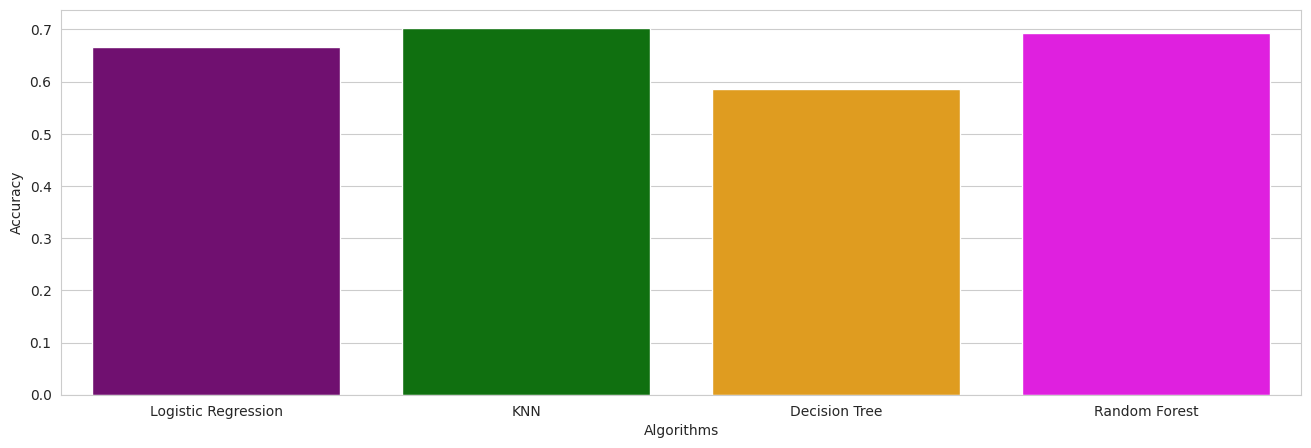

In [71]:
colors = ["purple", "green", "orange", "magenta", "blue", "white"]

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [76]:
y_head_lr = lr.predict(X_test)
knn3 = KNeighborsClassifier(n_neighbors = 1)
knn3.fit(X_train, y_train)
y_head_knn = knn3.predict(X_test)
y_head_dtc = dtc.predict(X_test)
y_head_rfc = rfc.predict(X_test)

In [77]:
from sklearn.metrics import confusion_matrix, classification_report

cm_lr = confusion_matrix(y_test, y_head_lr)
cm_knn = confusion_matrix(y_test, y_head_knn)
cm_dtc = confusion_matrix(y_test, y_head_dtc)
cm_rfc = confusion_matrix(y_test, y_head_rfc)

In [80]:
cr_lr = classification_report (y_test, y_head_lr)
cr_knn = classification_report (y_test, y_head_knn)

cr_dtc = classification_report (y_test, y_head_dtc)
cr_rfc = classification_report (y_test, y_head_rfc)
print("Отчет по классификации методом - Логистическая регрессия \n", cr_lr)
print("Отчет по классификации методом - Ближайший сосед \n", cr_knn)

print("Отчет по классификации методом - Деревья решений \n", cr_dtc)
print("Отчет по классификации методом - Лес \n", cr_rfc)

Отчет по классификации методом - Логистическая регрессия 
               precision    recall  f1-score   support

           0       0.69      0.96      0.80        77
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1

    accuracy                           0.67       111
   macro avg       0.05      0.07      0.06       111
weighted avg       0.48      0.67      0.56       111

Отчет по классификац

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [82]:
report = pd.DataFrame({'Method': list(accuracies.keys()), 'Accuracy': list(accuracies.values())})
print(report)

                Method  Accuracy
0  Logistic Regression  0.666667
1                  KNN  0.702703
2        Decision Tree  0.585586
3        Random Forest  0.693694
